In [1]:
import os
import signal
import sys
import time

import numpy as np
from lmfit import Model
from qcodes import ManualParameter

import quantify_core.visualization.pyqt_plotmon as pqm
from quantify_core.data.handling import set_datadir
from quantify_core.measurement.control import MeasurementControl
from quantify_core.utilities.examples_support import default_datadir
from quantify_core.visualization.instrument_monitor import InstrumentMonitor

rng = np.random.default_rng(seed=222222)  # random number generator

%matplotlib inline

In [2]:
# We recommend to always set the directory at the start of the python kernel
# and stick to a single common data directory for all
# notebooks/experiments within your measurement setup/PC
# This sets a default data directory for tutorial purposes. Change it to your
# desired data directory.

In [3]:
set_datadir(default_datadir())  # change me!

Data will be saved in:
/home/slavoutich/quantify-data


In [4]:
meas_ctrl = MeasurementControl("meas_ctrl")
plotmon = pqm.PlotMonitor_pyqt("plotmon_meas_ctrl")
meas_ctrl.instr_plotmon(plotmon.name)
insmon = InstrumentMonitor("Instruments Monitor")

In [5]:
# Note that in an actual experimental setup `freq` will be a QCoDeS parameter
# contained in a QCoDeS Instrument
freq = ManualParameter(name="frequency", unit="Hz", label="Frequency")
freq.batched = True  # Tells meas_ctrl that the setpoints are to be passed in batches


def lorenz(amplitude: float, fwhm: float, x: int, x_0: float):
    """Model of the frequency response."""
    return amplitude * ((fwhm / 2.0) ** 2) / ((x - x_0) ** 2 + (fwhm / 2.0) ** 2)


class Resonator:
    """
    Note that the Resonator is a valid Gettable not because of inheritance,
    but because it has the expected attributes and methods.
    """

    def __init__(self) -> None:
        self.name = "resonator"
        self.unit = "V"
        self.label = "Amplitude"
        self.batched = True
        self.delay = 0.0

        # hidden variables specifying the resonance
        self._test_resonance = 6.0001048e9  # in Hz
        self._test_width = 300  # FWHM in Hz

    def get(self) -> float:
        """Emulation of the frequency response."""
        time.sleep(self.delay)
        _lorenz = lambda x: lorenz(1, self._test_width, x, self._test_resonance)
        return 1 - np.array(list(map(_lorenz, freq())))

    def prepare(self) -> None:
        """Adding this print statement is not required but added for illustrative
        purposes."""
        print("\nPrepared Resonator...")

    def finish(self) -> None:
        """Adding this print statement is not required but added for illustrative
        purposes."""
        print("\nFinished Resonator...")


gettable_res = Resonator()

In [6]:
# At this point the `freq` parameter is empty
print(freq())

None


In [7]:
meas_ctrl.settables(freq)
meas_ctrl.setpoints(np.arange(6.0001e9, 6.00011e9, 5))
meas_ctrl.gettables(gettable_res)
dset = meas_ctrl.run()

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 frequency 
Batch size limit: 2000


Prepared Resonator...
100% completed | elapsed time:      0s | time left:      0s  last batch size:   2000  
100% completed | elapsed time:      0s | time left:      0s  last batch size:   2000  
Finished Resonator...


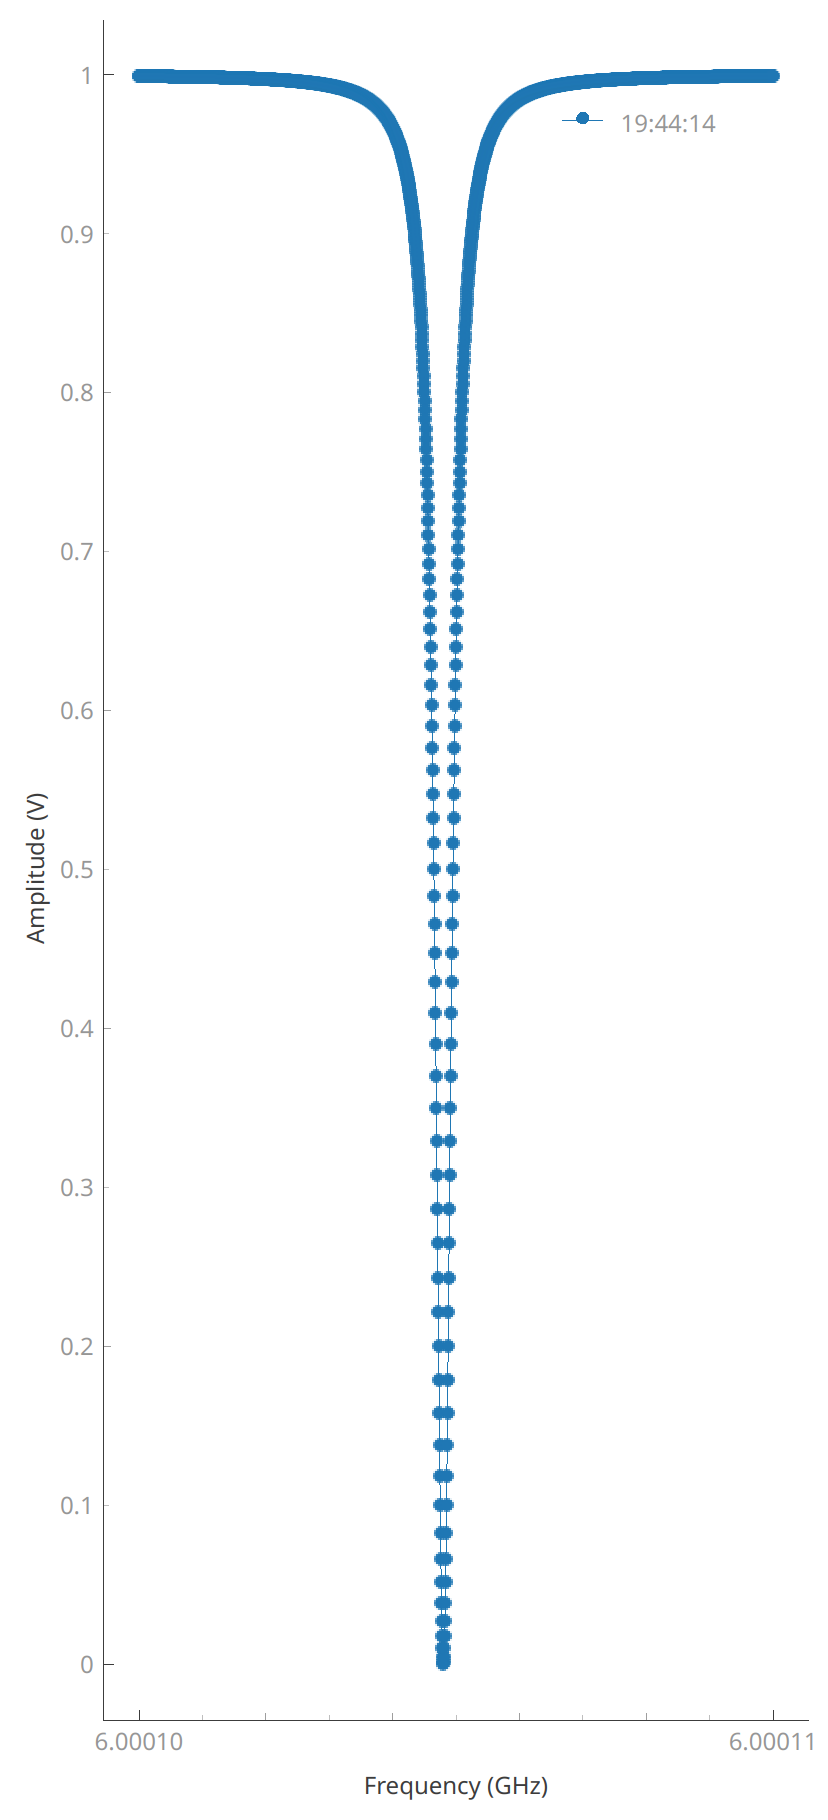

In [8]:
plotmon.main_QtPlot

In [9]:
# Tells meas_ctrl that only 256 datapoints can be processed at once
freq.batch_size = 256

gettable_res.delay = 0.05  # short delay for plotting
meas_ctrl.settables(freq)
meas_ctrl.setpoints(np.arange(6.0001e9, 6.00011e9, 5))
meas_ctrl.gettables(gettable_res)
dset = meas_ctrl.run()

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 frequency 
Batch size limit: 256


Prepared Resonator...
 12% completed | elapsed time:      0s | time left:      0s  last batch size:    256  
Prepared Resonator...

Prepared Resonator...

Prepared Resonator...



Prepared Resonator...

Prepared Resonator...

Prepared Resonator...

Prepared Resonator...


100% completed | elapsed time:      0s | time left:      0s  last batch size:    208  
100% completed | elapsed time:      0s | time left:      0s  last batch size:    208  
Finished Resonator...


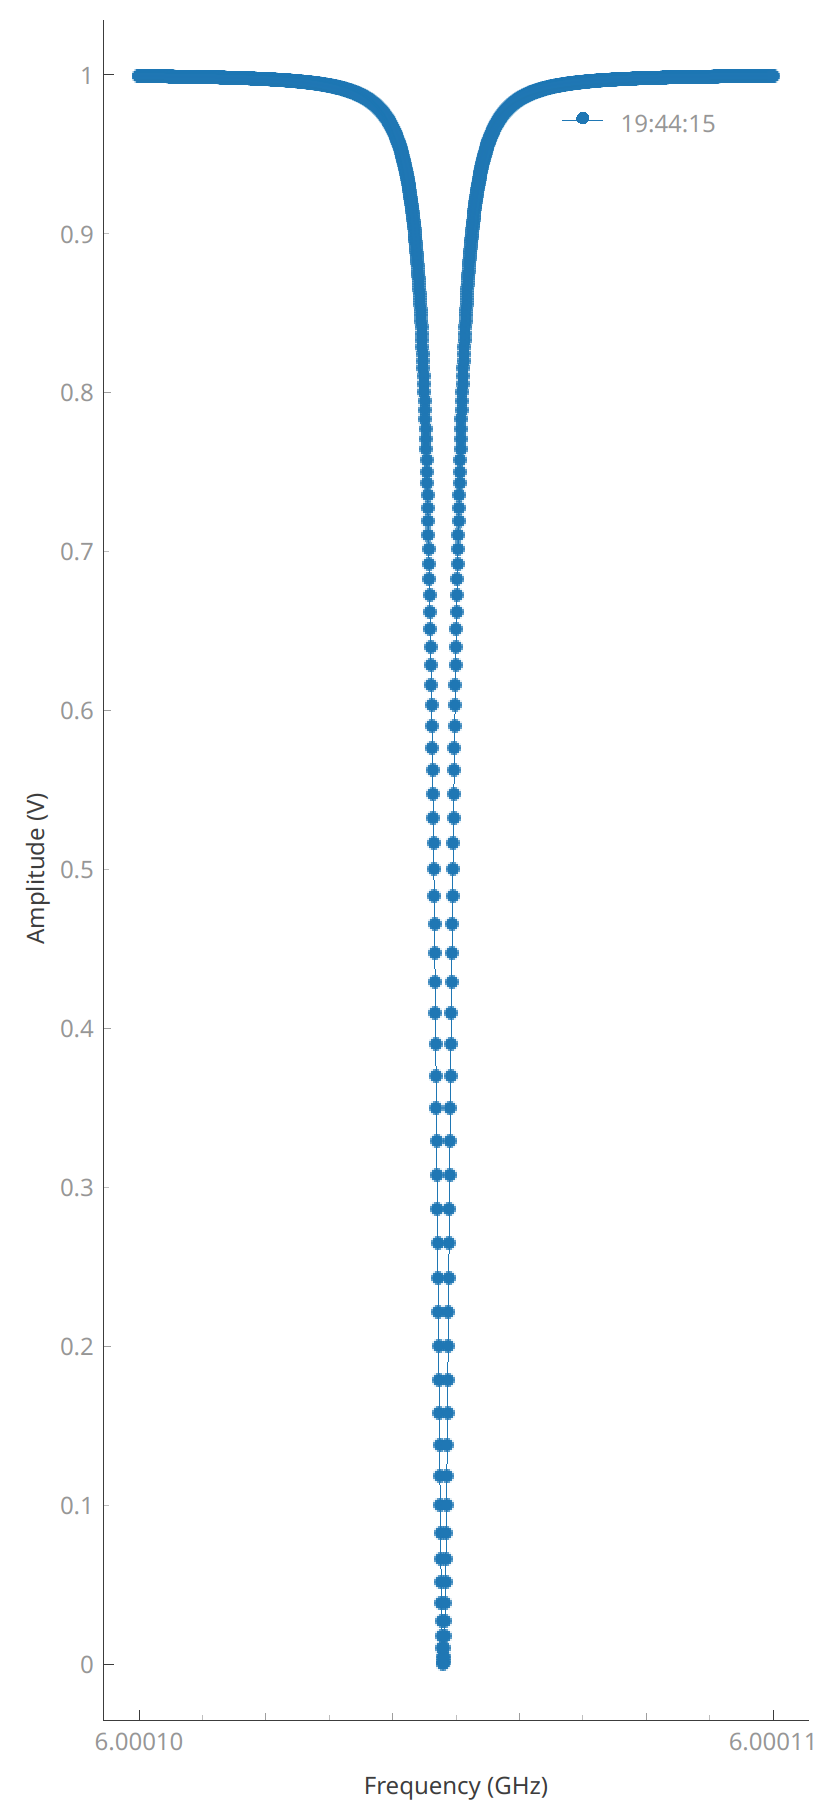

In [10]:
plotmon.main_QtPlot

In [11]:
def decay(t, tau):
    """T1 experiment decay model."""
    return np.exp(-t / tau)


time_par = ManualParameter(name="time", unit="s", label="Measurement Time")
# Tells meas_ctrl that the setpoints are to be passed in batches
time_par.batched = True


class MockQubit:
    """A mock qubit."""

    def __init__(self):
        self.name = "qubit"
        self.unit = "%"
        self.label = "High V"
        self.batched = True

        self.delay = 0.01  # sleep time in secs
        self.test_relaxation_time = 60e-6

    def get(self):
        """Adds a delay to be able to appreciate the data acquisition."""
        time.sleep(self.delay)
        rel_time = self.test_relaxation_time
        _func = lambda x: decay(x, rel_time) + rng.uniform(-0.1, 0.1)
        return np.array(list(map(_func, time_par())))

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 time 
Batch size limit: 300

100% completed | elapsed time:      0s | time left:      0s  last batch size:    300  
100% completed | elapsed time:      0s | time left:      0s  last batch size:    300  

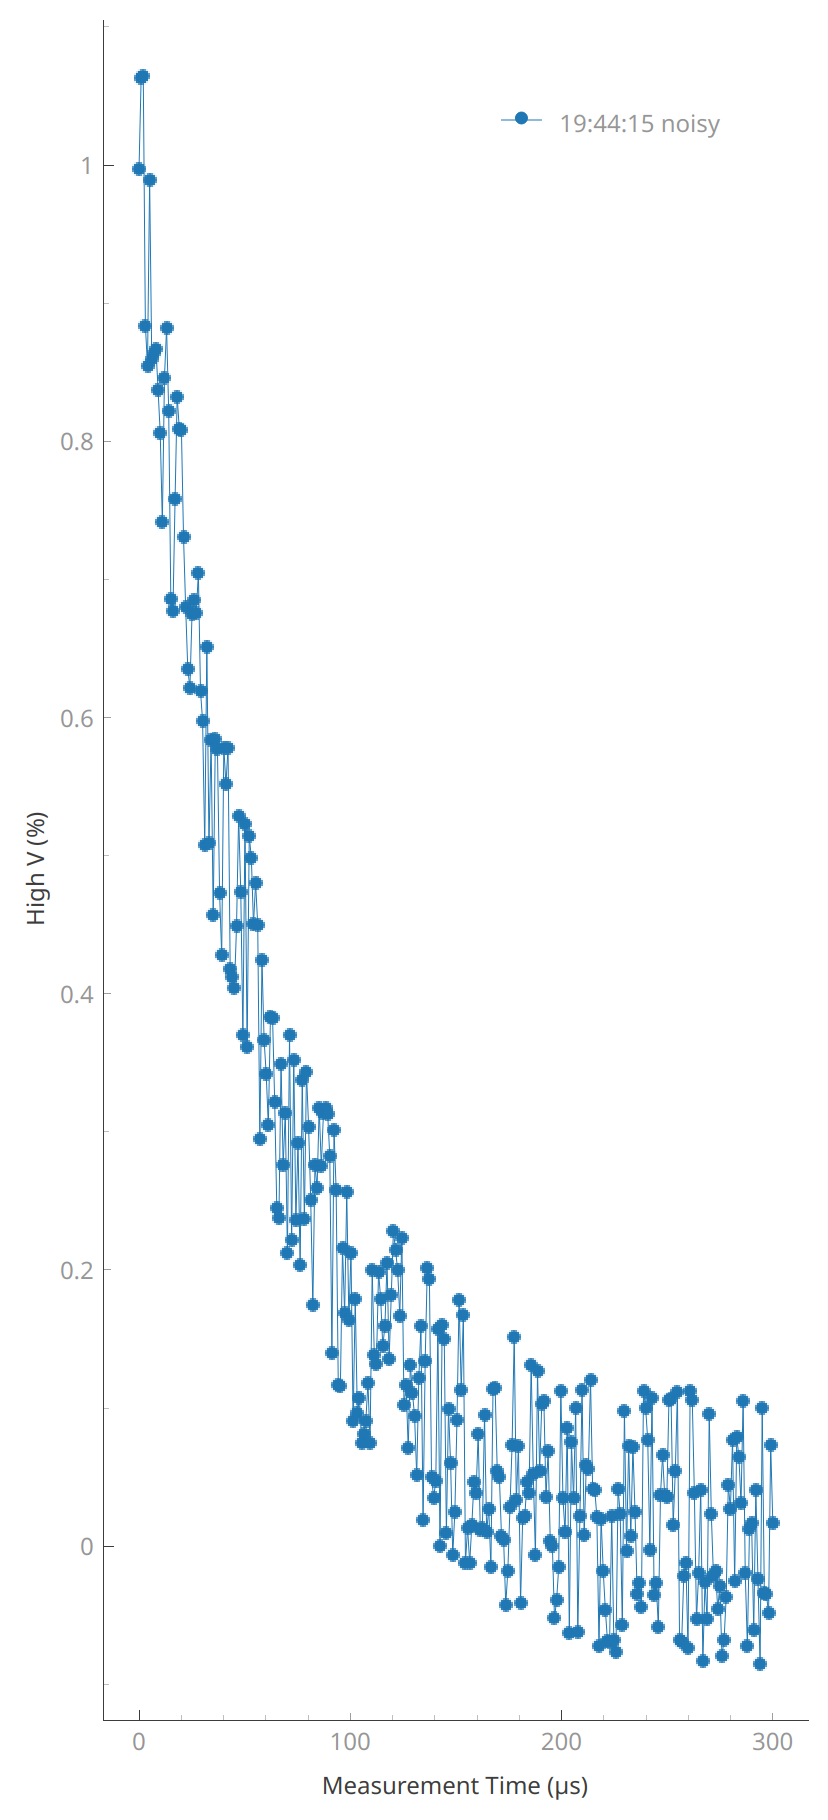

In [12]:
meas_ctrl.settables(time_par)
meas_ctrl.setpoints(np.linspace(0.0, 300.0e-6, 300))
meas_ctrl.gettables(MockQubit())
meas_ctrl.run("noisy")  # by default `.run` uses `soft_avg=1`
plotmon.main_QtPlot

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 time 
Batch size limit: 300

  6% completed | elapsed time:      0s | time left:      2s  last batch size:    300  

 51% completed | elapsed time:      0s | time left:      0s  last batch size:    300  

100% completed | elapsed time:      1s | time left:      0s  last batch size:    300  
100% completed | elapsed time:      1s | time left:      0s  last batch size:    300  

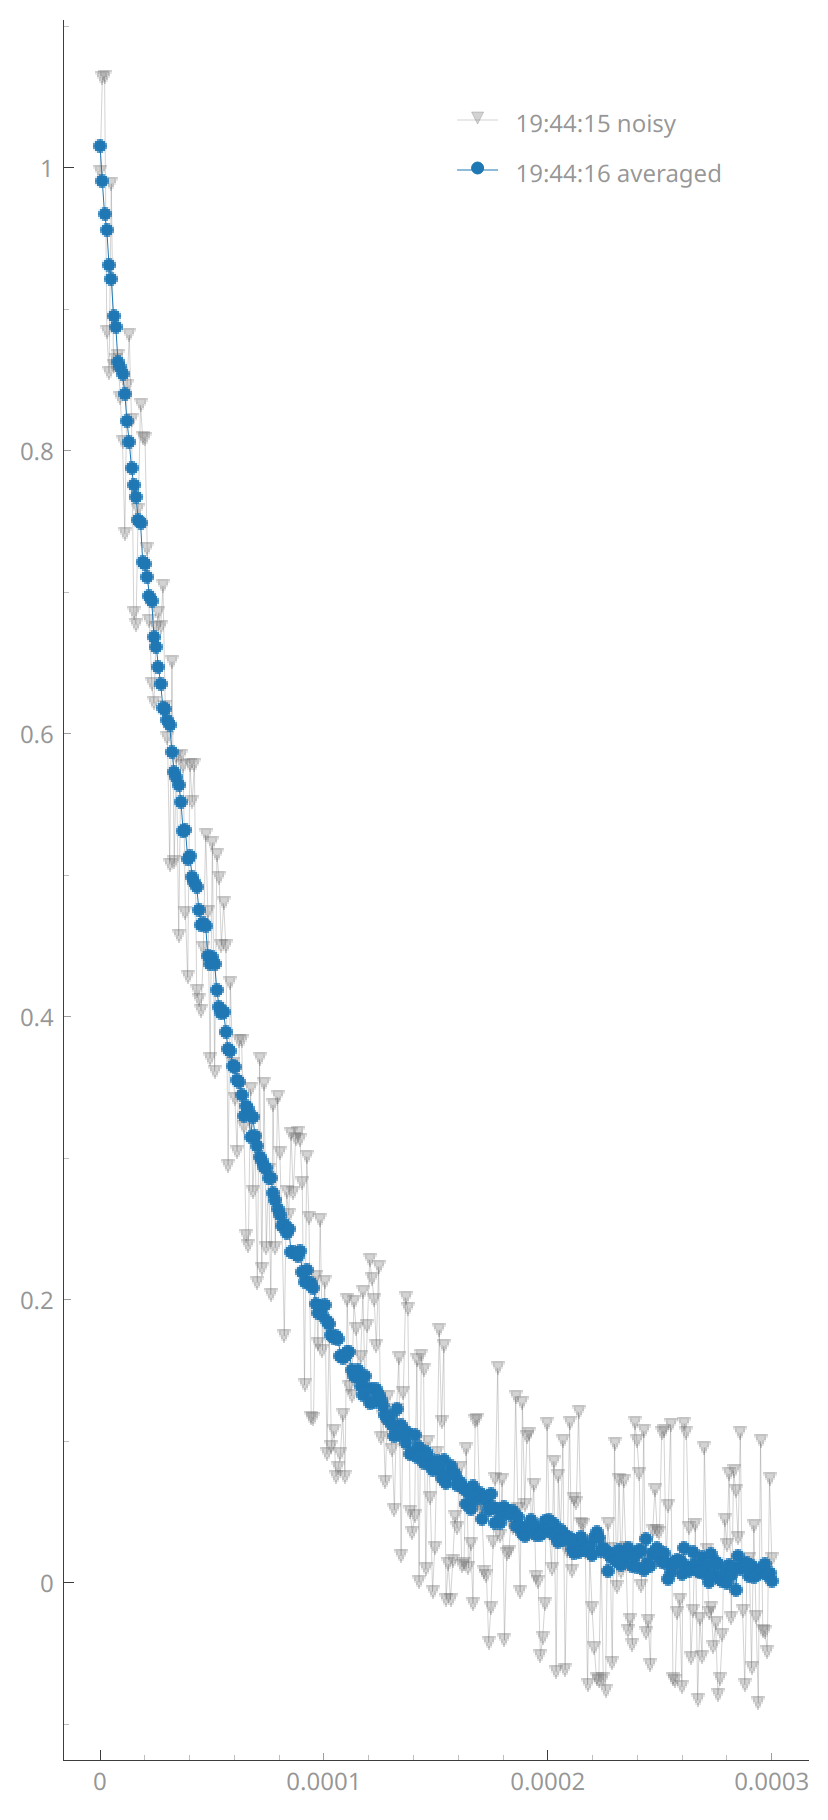

In [13]:
dset = meas_ctrl.run("averaged", soft_avg=100)
plotmon.main_QtPlot

{'tau': 5.9945424534072186e-05}

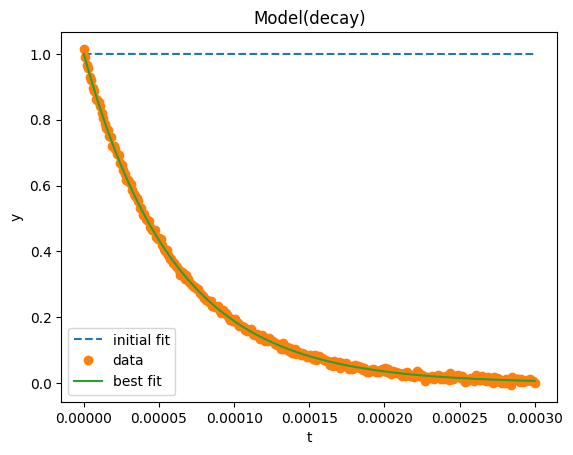

In [14]:
model = Model(decay, independent_vars=["t"])
fit_res = model.fit(dset["y0"].values, t=dset["x0"].values, tau=1)

fit_res.plot_fit(show_init=True)
fit_res.values

In [15]:

class SlowGettable:
    """A mock slow gettables."""

    def __init__(self):
        self.name = "slow"
        self.label = "Amplitude"
        self.unit = "V"

    def get(self):
        """Get method."""
        time.sleep(1.0)
        if time_par() == 4:
            # This same exception rises when pressing `ctrl` + `c`
            # or the "Stop kernel" button is pressed in a Jupyter(Lab) notebook
            if sys.platform == "win32":
                # Emulating the kernel interrupt on windows might have side effects
                raise KeyboardInterrupt
            os.kill(os.getpid(), signal.SIGINT)
        return time_par()


time_par.batched = False
meas_ctrl.settables(time_par)
meas_ctrl.setpoints(np.arange(10))
meas_ctrl.gettables(SlowGettable())
# Try interrupting me!
dset = meas_ctrl.run("slow")

Starting iterative measurement...


 10% completed | elapsed time:      1s | time left:      9s  

 20% completed | elapsed time:      2s | time left:      8s  

 30% completed | elapsed time:      3s | time left:      7s  

 40% completed | elapsed time:      4s | time left:      6s  



[!!!] 1 interruption(s) signaled. Stopping after this iteration/batch.
[Send 4 more interruptions to forcestop (not safe!)].

 50% completed | elapsed time:      5s | time left:      5s  
Interrupt signaled, exiting gracefully...


KeyboardInterrupt: Measurement interrupted

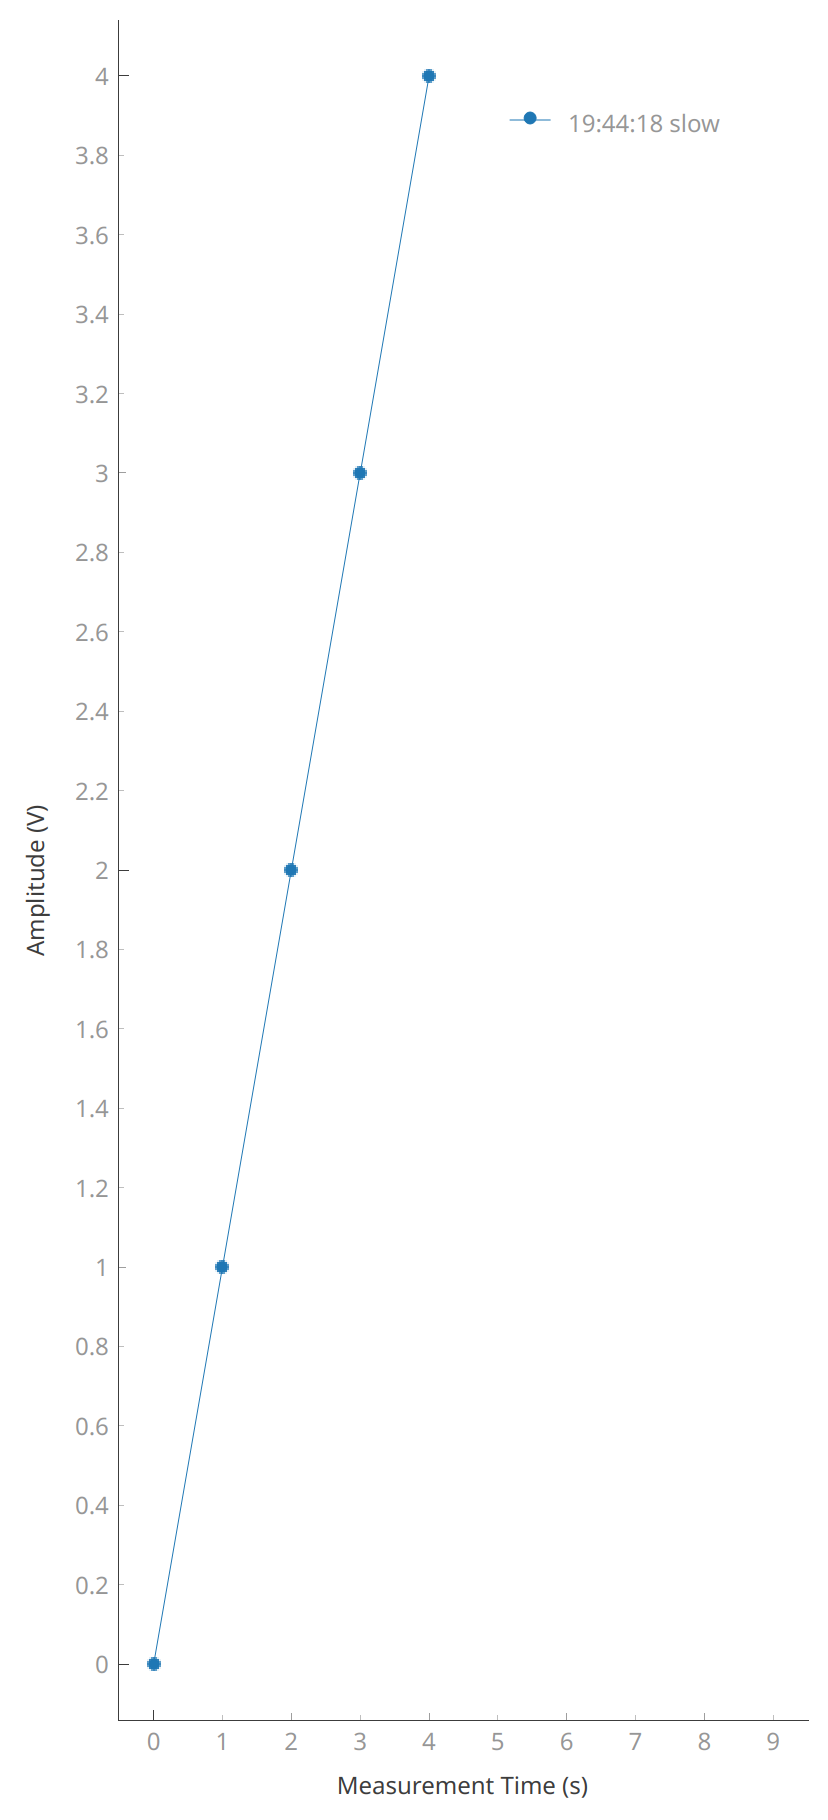

In [16]:
plotmon.main_QtPlot